In [1]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torchsummary as summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# importing the dataset
data = pd.read_csv('international-airline-passengers.csv')
data

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


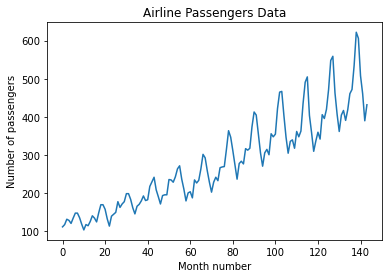

In [3]:
# plot the data
def plot(data):
    '''
    # If we consider that data of days in between is missing then uncomment this otherwise the code written down will be used 
    #simply.
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # no. of days in month
    cumulative_days = []
    sum_ = 0
    cumulative_days.append(sum_)
    for i in range(len(months)-1):
        sum_ += months[i]
        cumulative_days.append(sum_)
    
    dates = list(map(lambda a: cumulative_days[int(a[0])] + int(a[2:]), data['Month']))
    prices = data['Sales'].values
    
    
    plt.plot(dates, prices, 'r')
    plt.title('Day in the year vs sales')
    plt.scatter(dates, prices)
    plt.show()
    '''
    plt.plot(data.iloc[:-1, 1])
    plt.title("Airline Passengers Data")
    plt.xlabel("Month number")
    plt.ylabel("Number of passengers")
    plt.show()
####################################################    
plot(data)

In [4]:
# sliding windows is used to make the problem like supervised learning
def sliding_windows(data, seq_len):
    x = []
    y = []
    for i in range(data.shape[0] - seq_len - 1): 
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(x), np.array(y)

In [5]:
# forming the train and test sets
passengers = data.iloc[:-1, 1:2 ].values
sc = MinMaxScaler()
training_data = sc.fit_transform(passengers)

# transforming the data into form of sequences
seq_len = 4
x, y = sliding_windows(training_data, seq_len)

# setting training and testing sizes
train_size = (70*x.shape[0])//100# 70%
test_size = x.shape[0] - train_size

#transforming the numpy vectors into tensors

data_x = Variable(torch.Tensor(np.array(x)))
data_y = Variable(torch.Tensor(np.array(y)))

train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

test_x = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
test_y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))  # we could have selected the train and test data randomly also    


In [6]:
# network structure of lstm 
class network(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_len):
        super(network, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [7]:
# hparams
num_epochs = 1000
learning_rate = 0.01
seq_len = 4
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1 # here classes don't have a meaning

lstm = network(num_classes, input_size, hidden_size, num_layers, seq_len).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#summary(lstm, train_x.shape)

In [8]:
# training loop which is much simpler
def train(num_epochs, learning_rate, lstm, criterion, optimizer):
    losses = []
    for epoch in range(num_epochs+1):
        inputs = train_x.to(device)
        y_orig = train_y.to(device)
        
        outputs = lstm(inputs)
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, y_orig)
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    plt.plot(range(num_epochs+1), losses)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

Epoch: 0, loss: 0.08778
Epoch: 100, loss: 0.01187
Epoch: 200, loss: 0.00351
Epoch: 300, loss: 0.00281
Epoch: 400, loss: 0.00221
Epoch: 500, loss: 0.00194
Epoch: 600, loss: 0.00185
Epoch: 700, loss: 0.00184
Epoch: 800, loss: 0.00184
Epoch: 900, loss: 0.00183
Epoch: 1000, loss: 0.00183


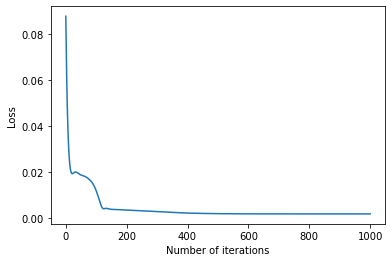

In [9]:
train(num_epochs, learning_rate, lstm, criterion, optimizer)

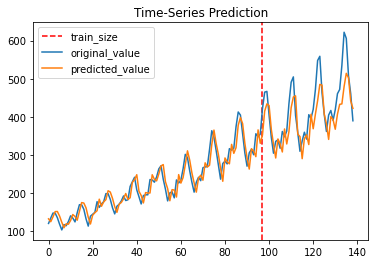

In [10]:
# prediction on the training and testing set
train_predict = lstm(data_x.to(device))

data_predict = train_predict.data.cpu().numpy()
data_y_plot = data_y.data.cpu().numpy()

data_predict = sc.inverse_transform(data_predict) # rescaling the values to original values 
data_y_plot = sc.inverse_transform(data_y_plot)    

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(data_y_plot)
plt.plot(data_predict)
plt.title('Time-Series Prediction')
plt.legend(["train_size", "original_value", "predicted_value"], loc='upper left')
plt.show()
    